In [252]:
import os
import sys
import time
import pandas as pd
import numpy as np
from os import listdir
from generate_epoch import * # make sure to have this file inside the ML folder
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
from neurodsp import filt
import random
import biosig
import json
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_gdf
# for models:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
import pyeeg
from sklearn.metrics import accuracy_score

In [2]:
sample_data_folder = 'BCICIV_2b_gdf'
sample_data_raw_files = os.listdir(sample_data_folder)
sample_data_raw_files = [sample_data_folder + '/' + i for i in sample_data_raw_files if '.gdf' in i] 
sample_data_raw_files_train = [i for i in sample_data_raw_files if 'T' in i] 
sample_data_raw_files_test = [i for i in sample_data_raw_files if 'E' in i]
sample_data_raw_files_train.sort()
sample_data_raw_files_test.sort()

In [3]:
raws_train = [read_raw_gdf(f, preload=True) for f in sample_data_raw_files_train]
raws_test = [read_raw_gdf(f, preload=True) for f in sample_data_raw_files_test]
headers_train = [json.loads(biosig.header(f)) for f in sample_data_raw_files_train]
headers_test = [json.loads(biosig.header(f)) for f in sample_data_raw_files_test]
for r in raws_train:
    r.set_channel_types({'EEG:C3':'eeg', 'EEG:Cz':'eeg', 'EEG:C4':'eeg', 'EOG:ch01':'eog', 'EOG:ch02': 'eog',\
                      'EOG:ch03':'eog'})
    r.rename_channels({'EEG:C3':'C3', 'EEG:Cz':'Cz', 'EEG:C4':'C4'})
    ten_twenty_montage = make_standard_montage('standard_1020')
    r.set_montage(ten_twenty_montage)
for r in raws_test:
    r.set_channel_types({'EEG:C3':'eeg', 'EEG:Cz':'eeg', 'EEG:C4':'eeg', 'EOG:ch01':'eog', 'EOG:ch02': 'eog',\
                      'EOG:ch03':'eog'})
    r.rename_channels({'EEG:C3':'C3', 'EEG:Cz':'Cz', 'EEG:C4':'C4'})
    ten_twenty_montage = make_standard_montage('standard_1020')
    r.set_montage(ten_twenty_montage)
dfs_train = [r.to_data_frame() for r in raws_train]
dfs_test = [r.to_data_frame() for r in raws_test]

Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0101T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0102T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0103T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469010  =      0.000 ...  1876.040 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0201T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0202T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0203T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464154  =      0.000 ...  1856.616 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0301T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0302T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0303T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0401T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0402T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696265  =      0.000 ...  2785.060 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0403T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 468558  =      0.000 ...  1874.232 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0501T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0502T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696265  =      0.000 ...  2785.060 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0503T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 461874  =      0.000 ...  1847.496 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0601T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0602T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0603T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 470390  =      0.000 ...  1881.560 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0701T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0702T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0703T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 466726  =      0.000 ...  1866.904 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0801T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 787728  =      0.000 ...  3150.912 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0802T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0803T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 474834  =      0.000 ...  1899.336 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0901T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0902T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0903T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460730  =      0.000 ...  1842.920 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0104E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 466313  =      0.000 ...  1865.252 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0105E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 474362  =      0.000 ...  1897.448 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0204E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361829  =      0.000 ...  1447.316 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0205E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 473686  =      0.000 ...  1894.744 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0304E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0305E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 463618  =      0.000 ...  1854.472 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0404E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 467478  =      0.000 ...  1869.912 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0405E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 466050  =      0.000 ...  1864.200 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0504E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 417019  =      0.000 ...  1668.076 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0505E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464958  =      0.000 ...  1859.832 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0604E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469990  =      0.000 ...  1879.960 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0605E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460902  =      0.000 ...  1843.608 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0704E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 470343  =      0.000 ...  1881.372 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0705E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460894  =      0.000 ...  1843.576 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0804E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 474834  =      0.000 ...  1899.336 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0805E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464306  =      0.000 ...  1857.224 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0904E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 466802  =      0.000 ...  1867.208 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


Extracting EDF parameters from /Users/simonfei/Motor-Imagery-App-Project/ML/BCICIV_2b_gdf/B0905E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 458570  =      0.000 ...  1834.280 secs...


/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/mne/io/edf/edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


In [4]:
events_train = [i['EVENT'] for i in headers_train]
events_test = [i['EVENT'] for i in headers_test]

stims_train = []
for event in events_train:
    s = []
    for e in event:
        if e['TYP'] == '0x0301' or e['TYP'] == '0x0302':
            s.append(e)
    stims_train.append(s)
    
stims_test = []
for event in events_test:
    s = []
    for e in event:
        #if e['TYP'] == '0x0301' or e['TYP'] == '0x0302':
        if e['TYP'] == '0x030f': #unknown cue
            s.append(e)
    stims_test.append(s)
    
stim_times_train = []
for stims in stims_train:
    st = []
    for s in stims:
        st.append(round(s['POS'] * 1000))
    stim_times_train.append(st)

stim_times_test = []
for stims in stims_test:
    st = []
    for s in stims:
        st.append(round(s['POS'] * 1000))
    stim_times_test.append(st)
    
fbe_train = []
for df in dfs_train:
    fbe = []
    for i in range(len(df)):
        fbe.append(0)
    fbe_train.append(fbe)

for i in range(len(stim_times_train)):
    fbe = fbe_train[i]
    sts = stim_times_train[i]
    for st in sts:
        fbe[round(st/4)] = 1
        
fbe_test = []
for df in dfs_test:
    fbe = []
    for i in range(len(df)):
        fbe.append(0)
    fbe_test.append(fbe)

for i in range(len(stim_times_test)):
    fbe = fbe_test[i]
    sts = stim_times_test[i]
    for st in sts:
        fbe[round(st/4)] = 1

for i in range(len(fbe_train)):
    df = dfs_train[i]
    fbe = fbe_train[i]
    df['EventStart'] = fbe

for i in range(len(fbe_test)):
    df = dfs_test[i]
    fbe = fbe_test[i]
    df['EventStart'] = fbe

In [5]:
sample_data_raw_csvs_train = [f[-10:-4] + '.csv' for f in sample_data_raw_files_train]
sample_data_raw_csvs_test = [f[-10:-4] + '.csv' for f in sample_data_raw_files_test]
for i in range(len(sample_data_raw_csvs_train)):
    f = sample_data_raw_csvs_train[i]
    dfs_train[i].to_csv('data/train/' + f, index = False)
for i in range(len(sample_data_raw_csvs_test)):
    f = sample_data_raw_csvs_test[i]
    dfs_test[i].to_csv('data/test/' + f, index = False)
labels_folder = 'data/y'
label_files = os.listdir(labels_folder)
label_files = [i for i in label_files if '.csv' in i]
label_files = ['data/y/' + i for i in label_files]
label_files_train = [i for i in label_files if 'T' in i]
label_files_test = [i for i in label_files if 'E' in i]
label_files_train.sort()
label_files_test.sort()
labels_train = [pd.read_csv(f, header = None) for f in label_files_train]
labels_test = [pd.read_csv(f, header = None) for f in label_files_test]
labels_train = [i[:120] for i in labels_train]
labels_test = [i[:120] for i in labels_test]
labels_train = pd.concat(labels_train)
labels_test = pd.concat(labels_test)
labels_train.to_csv('data/TrainLabels.csv', index = False, header = None)
labels_test.to_csv('data/true_labels.csv', index = False, header = None)

# epoching

In [6]:
train_list_arr = np.array(sorted(listdir('data/train')))
total_training_participant = 9
trial_per_subj = 3 # 9 x 3 = 27 csv files in total
train_list_arr = train_list_arr[1:]
train_list_np = np.reshape(train_list_arr, (total_training_participant,trial_per_subj))
test_list_arr = np.array(sorted(listdir('data/test')))
total_testing_participant = 9
test_trial_per_subj = 2
test_list_arr = test_list_arr[1:]
test_list_np = np.reshape(test_list_arr, (total_testing_participant,test_trial_per_subj))

In [7]:
stimulus_per_subj = 360
stimulus_per_subj_test = 240
channels = ['C3','Cz','C4']
epoch_s = 0
epoch_e = 4000 #4 seconds
fs = 250
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))
train_data_list = np.empty((0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty((0, stimulus_per_subj_test, len(channels), epoch_len), float)

In [8]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
    return data

In [10]:
bl_s = -400
bl_e = -300
for training_participant_id in range(total_training_participant):
    subject_dir_list = train_list_np[training_participant_id]
    subject_epoch = np.empty((0, len(channels), epoch_len), float)
    for trial_id in range(trial_per_subj):
        subject_dir = subject_dir_list[trial_id]
        data = generate_epoch(file_path = 'data/train/'+subject_dir, channels = channels, \
                              eeg_filter = butter_bandpass_filter, fs = fs, epoch_s = epoch_s, \
                              epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
        subject_epoch = np.vstack((subject_epoch, data))
    subject_epoch = np.reshape(subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
    train_data_list = np.vstack((train_data_list, subject_epoch))

print('Epoched training data shape: '+ str(train_data_list.shape))

for testing_participant_id in range(total_testing_participant):
    subject_dir_list = test_list_np[testing_participant_id]
    subject_epoch = np.empty((0, len(channels), epoch_len), float)
    for trial_id in range(test_trial_per_subj):
        subject_dir = subject_dir_list[trial_id]
        data = generate_epoch(file_path = 'data/test/'+subject_dir, channels = channels, \
                              eeg_filter = butter_bandpass_filter, fs = fs, epoch_s = epoch_s, \
                              epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
        subject_epoch = np.vstack((subject_epoch, data))
    subject_epoch = np.reshape(subject_epoch, (1, stimulus_per_subj_test, len(channels), epoch_len))
    test_data_list = np.vstack((test_data_list, subject_epoch))

print('Epoched testing data shape: '+ str(test_data_list.shape))
y = pd.read_csv('data/TrainLabels.csv', header = None)
y = y.values.reshape(3240,)
print(y.shape)
yT = pd.read_csv('data/true_labels.csv', header = None) # put your train label path here
yT = yT.values.reshape(2160,)
print(yT.shape)

Epoched training data shape: (9, 360, 3, 1000)
Epoched testing data shape: (9, 240, 3, 1000)
(3240,)
(2160,)


# generateModel(X, Y)

In [235]:
X_train = train_data_list[2]
X_test = test_data_list[2]
Y_train = y[360*2:360*2+360]
Y_test = yT[240*2:240*2+240]

In [232]:
class myModel:
    def __init__(self):
        pass
    def fit(X, Y):
        pass
    def predict(X):
        pass
    
class XDawnLRModel(myModel): # XDAWN Covariance Preprocessing + Linear Regression Classifier
    def __init__(self):
        super().__init__()
        self.XC = XdawnCovariances(nfilter = 1) # the number of filters can be changed
        self.logreg = LogisticRegression()
        
    def fit(self, X, Y):
        X_transformed = self.XC.fit_transform(X, Y)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        return self.logreg.fit(X_transformed,Y)
        
    def predict(self, X):
        X_transformed = self.XC.transform(X)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        return self.logreg.predict(X_transformed)

model = XDawnLRModel()
history = model.fit(X_train, Y_train)

In [227]:
Y_pred = model.predict(X_train)
print(classification_report(Y_train, Y_pred))
print(cohen_kappa_score(Y_train, Y_pred))

              precision    recall  f1-score   support

           1       0.76      0.67      0.71       180
           2       0.71      0.79      0.75       180

    accuracy                           0.73       360
   macro avg       0.73      0.73      0.73       360
weighted avg       0.73      0.73      0.73       360

0.46111111111111114


In [228]:
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [236]:
sub_binning=[0.5, 4, 7, 12, 30]
sub_intervals = getIntervals(sub_binning)
power_ratio1=[getPowerRatio(data[:], sub_binning) for data in X_train[:,0,:]]
power_ratio2=[getPowerRatio(data[:], sub_binning) for data in X_train[:,1,:]]
power_ratio3=[getPowerRatio(data[:], sub_binning) for data in X_train[:,2,:]]

power_ratiot1=[getPowerRatio(data[:], sub_binning) for data in X_test[:,0,:]]
power_ratiot2=[getPowerRatio(data[:], sub_binning) for data in X_test[:,1,:]]
power_ratiot3=[getPowerRatio(data[:], sub_binning) for data in X_test[:,2,:]]
power_ratio = []
for i,j,k in zip(power_ratio1,power_ratio2,power_ratio3):
    power_ratio.append(np.concatenate([i,j,k], axis = 0))
    
power_ratiot = []
for i,j,k in zip(power_ratiot1,power_ratiot2,power_ratiot3):
    power_ratiot.append(np.concatenate([i,j,k], axis = 0))

In [230]:
model = LinearDiscriminantAnalysis()
model.fit(power_ratio, Y_train)
Y_pred = model.predict(power_ratio)
print(classification_report(Y_train, Y_pred))
print(cohen_kappa_score(Y_train, Y_pred))

              precision    recall  f1-score   support

           1       0.59      0.59      0.59       180
           2       0.59      0.58      0.58       180

    accuracy                           0.59       360
   macro avg       0.59      0.59      0.59       360
weighted avg       0.59      0.59      0.59       360

0.17222222222222228


In [242]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='linear'), power_ratio, Y_train, cv=5)

In [243]:
train_scores

array([[0.64285714, 0.57142857, 0.57142857, 0.57142857, 0.57142857],
       [0.50537634, 0.50537634, 0.50537634, 0.50537634, 0.50537634],
       [0.50632911, 0.50632911, 0.50632911, 0.55696203, 0.55696203],
       [0.50224215, 0.50224215, 0.50224215, 0.53363229, 0.50672646],
       [0.52083333, 0.53125   , 0.52430556, 0.56944444, 0.55902778]])

In [244]:
valid_scores

array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.47222222],
       [0.5       , 0.51388889, 0.5       , 0.47222222, 0.51388889],
       [0.59722222, 0.41666667, 0.56944444, 0.44444444, 0.51388889]])

In [245]:
train_sizes

array([ 28,  93, 158, 223, 288])

In [246]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/Users/simonfei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

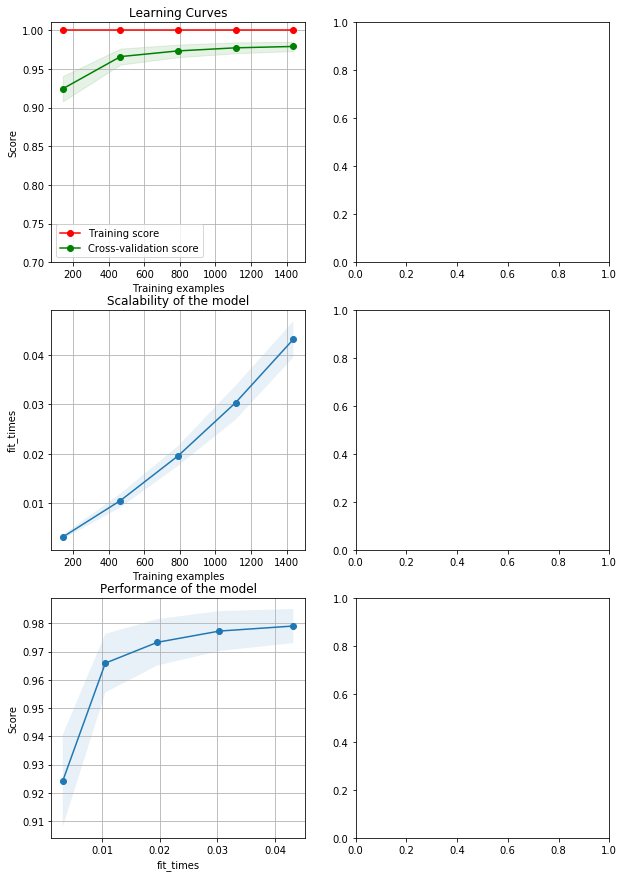

In [255]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
X, y = load_digits(return_X_y=True)
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
